# Influenza data analysis

Taken from *Time Series and its Applications - with R Examples, 3rd ed*:
<table>
    <tr>
        <th>example</th>
        <th>page</th>
        <th>title</th>
    </tr>
    <tr>
        <td>[5.7](#Fitting a SETARMA model)</td>
        <td>264</td>
        <td style = "text-align: left">Threshold Modeling of the Influenza Series</td>
    </tr>
</table>

## Description of the time series

The time series shows monthly pneumonia and influenza deaths per 10,000 people in the years 1968 to 1978. The number of deaths tend to inrcease faster than it decreases during epidemics. Number ofdeaths is typically largest during winter months, but the data is not perfectly seasonal.

## Initialization

Load the ASTSA package:

In [1]:
library(astsa)

Load package for threshold modeling:

In [2]:
library(tsDyn)

Load switching AR package:

In [3]:
library(MSwM)

Loading required package: nlme
Loading required package: parallel


## Raw data visualization

_Taken from ex. 5.7._

Plot the datasets:

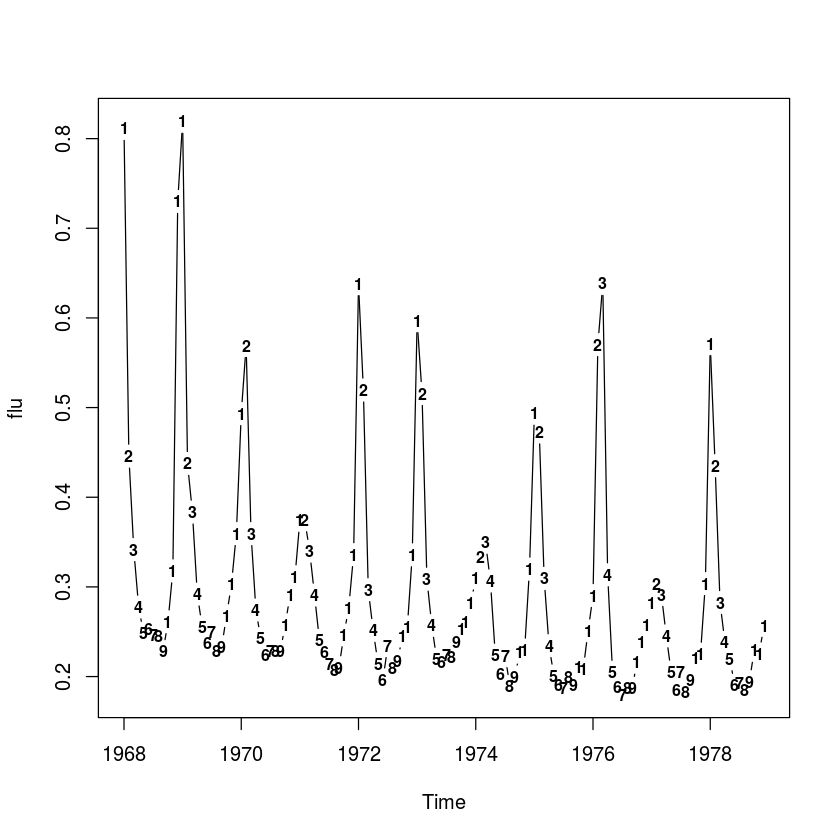

In [11]:
plot(flu, type = "c")
Months = c("1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12")
points(flu, pch = Months, cex = 0.8, font = 2)

Take the first difference of the flu data:

In [12]:
dflu = diff(flu)

Plot the differenced flu data against its first lag:

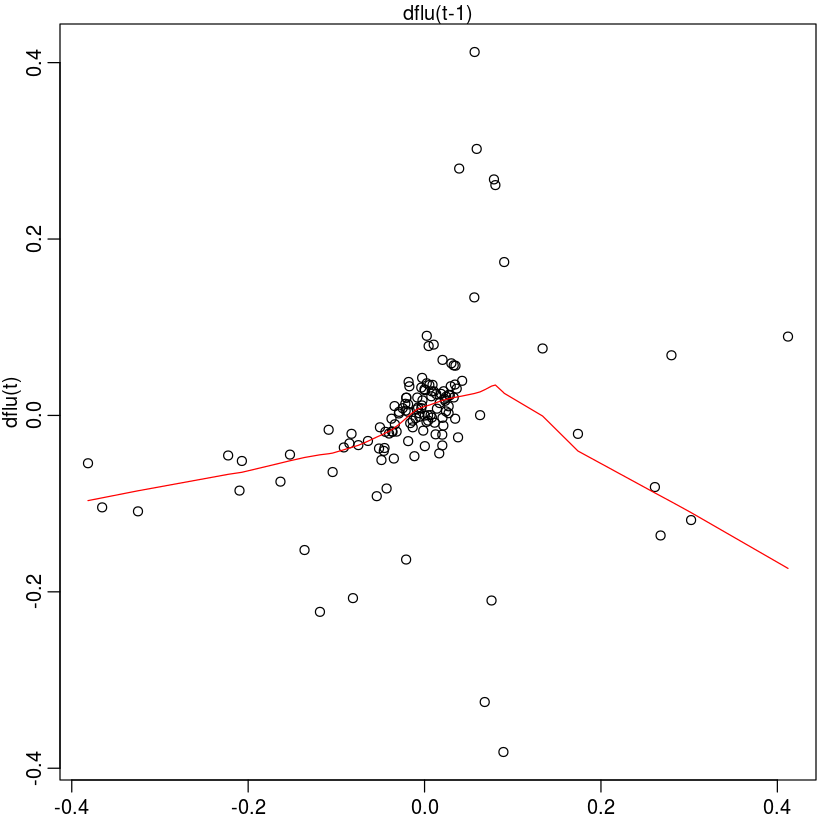

In [14]:
lag1.plot(dflu, corr = FALSE)

Split the data into two sets, where $\text{dflu}[t - 1] < 0.5$ and $\text{dflu}[t - 1] \ge 0.5$:

In [16]:
thrsh = 0.05
Z = ts.intersect(dflu, lag(dflu, -1), lag(dflu, -2), lag(dflu, -3), lag(dflu, -4))
ind1 = ifelse(Z[, 2] < thrsh, 1, NA)
ind2 = ifelse(Z[, 2] < thrsh, NA, 1)
X1 = Z[, 1]*ind1
X2 = Z[, 1]*ind2

### Fitting a SETARMA model

We fit the following threshold model using:

\begin{align*}
x[t] &= \alpha^{(1)} + \sum_{j = 1}^{p} \phi_{j}^{(1)} x[t - j] + w_{j}^{(1)} \quad \text{for} \; x[t - 1] < 0.05 \\
x[t] &= \alpha^{(2)} + \sum_{j = 1}^{p} \phi_{j}^{(2)} x[t - j] + w_{j}^{(2)} \quad \text{for} \; x[t - 1] \ge 0.05 \\
\end{align*}

where $p = 4$. The code for fitting is found below:

In [23]:
# summary of the fit
summary(fit1 <- lm(X1~ Z[, 2:5]))
summary(fit2 <- lm(X2~ Z[, 2:5]))

# create the design matrix
D = cbind(rep(1, nrow(Z)), Z[, 2:5])

# obtain predictions from data
p1 = D %*% coef(fit1)
p2 = D %*% coef(fit2)

prd = ifelse(Z[, 2] < thrsh, p1, p2)


Call:
lm(formula = X1 ~ Z[, 2:5])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.13312 -0.02049  0.00218  0.01667  0.26666 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            0.004471   0.004894   0.914 0.363032    
Z[, 2:5]lag(dflu, -1)  0.506650   0.078319   6.469  3.2e-09 ***
Z[, 2:5]lag(dflu, -2) -0.200086   0.056573  -3.537 0.000604 ***
Z[, 2:5]lag(dflu, -3)  0.121047   0.054463   2.223 0.028389 *  
Z[, 2:5]lag(dflu, -4) -0.110938   0.045979  -2.413 0.017564 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.04578 on 105 degrees of freedom
  (17 observations deleted due to missingness)
Multiple R-squared:  0.3763,	Adjusted R-squared:  0.3526 
F-statistic: 15.84 on 4 and 105 DF,  p-value: 3.568e-10



Call:
lm(formula = X2 ~ Z[, 2:5])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.089975 -0.036825 -0.006328  0.040765  0.129509 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)            0.40794    0.04675   8.726 1.53e-06 ***
Z[, 2:5]lag(dflu, -1) -0.74833    0.16644  -4.496 0.000732 ***
Z[, 2:5]lag(dflu, -2) -1.03231    0.21137  -4.884 0.000376 ***
Z[, 2:5]lag(dflu, -3) -2.04504    1.05000  -1.948 0.075235 .  
Z[, 2:5]lag(dflu, -4) -6.71178    1.24538  -5.389 0.000163 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0721 on 12 degrees of freedom
  (110 observations deleted due to missingness)
Multiple R-squared:  0.9207,	Adjusted R-squared:  0.8943 
F-statistic: 34.85 on 4 and 12 DF,  p-value: 1.618e-06


Plot the predictions:

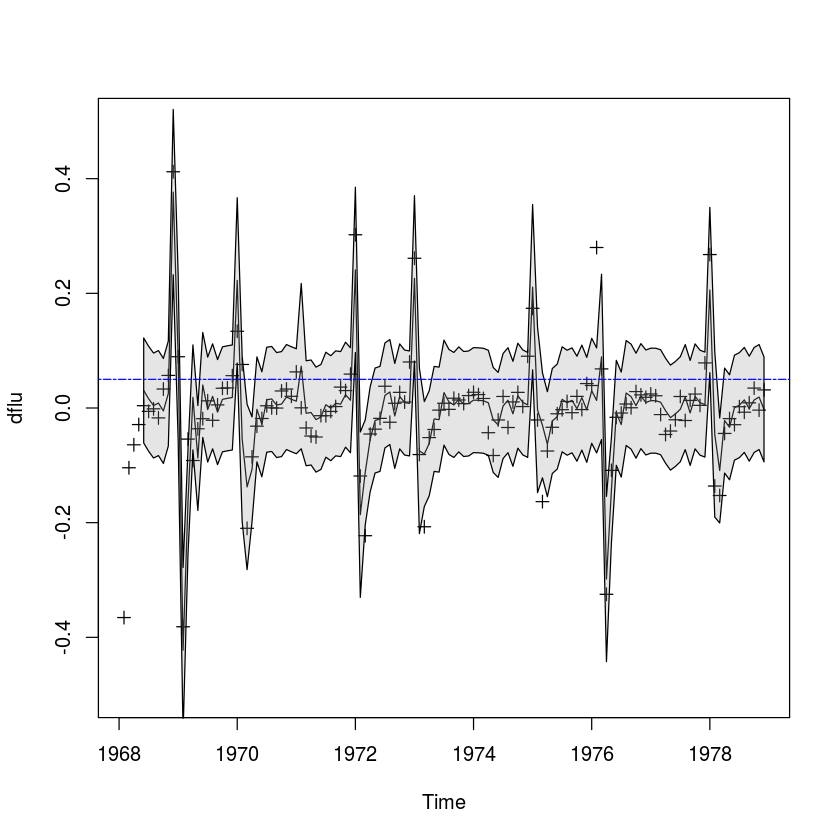

In [28]:
plot(dflu, ylim = c(-0.5, 0.5), type = "p", pch = 3)
lines(prd)

# get mean squared error of fit for both models
prde1 = sqrt(sum(resid(fit1)^2)/df.residual(fit1))
prde2 = sqrt(sum(resid(fit2)^2)/df.residual(fit2))
prde = ifelse(Z[, 2] < thrsh, prde1, prde2)

# plot confidence intervals
tx = time(dflu)[-(1:4)]
xx = c(tx, rev(tx))
yy = c(prd - 2*prde, rev(prd + 2*prde))
polygon(xx, yy, border = 9, col = gray(0.6, alpha = 0.25))
abline(h = 0.05, col = 4, lty = 6)

### Fitting a SETARMA model using tsDyn

The `tsDyn` package can be used to the same effect as what was done above:

Warning message:
“
With the threshold you gave (0.05) there is a regime with less than trim=15% observations (86.61%, 13.39%, )
”


 1 T: Trim not respected:  0.8661417 0.1338583 from th: 0.05

Warning message:
“Possible unit root in the high  regime. Roots are: 0.6182 0.6244 0.6244 0.6182”


Non linear autoregressive model

SETAR model ( 2 regimes)
Coefficients:
Low regime:
     const.L       phiL.1       phiL.2       phiL.3       phiL.4 
 0.004471044  0.506649694 -0.200086031  0.121047354 -0.110938271 

High regime:
   const.H     phiH.1     phiH.2     phiH.3     phiH.4 
 0.4079353 -0.7483325 -1.0323129 -2.0450407 -6.7117769 

Threshold:
-Variable: Z(t) = + (1) X(t)+ (0)X(t-1)+ (0)X(t-2)+ (0)X(t-3)
-Value: 0.05 (fixed)
Proportion of points in low regime: 86.61% 	 High regime: 13.39% 

Warning message:
“Possible unit root in the high  regime. Roots are: 0.8074 0.8074 1.3596 1.3596”


Non linear autoregressive model

SETAR model ( 2 regimes)
Coefficients:
Low regime:
      const.L        phiL.1        phiL.2        phiL.3        phiL.4 
 0.0006269563  0.4608089284 -0.2243720404  0.1100931813 -0.1307031988 

High regime:
   const.H     phiH.1     phiH.2     phiH.3     phiH.4 
 0.2035231 -0.4071318 -1.4686776  0.3768388 -0.8298225 

Threshold:
-Variable: Z(t) = + (1) X(t)+ (0)X(t-1)+ (0)X(t-2)+ (0)X(t-3)
-Value: 0.03646
Proportion of points in low regime: 84.25% 	 High regime: 15.75% 

[1] -678.5372

[1] -710.1644

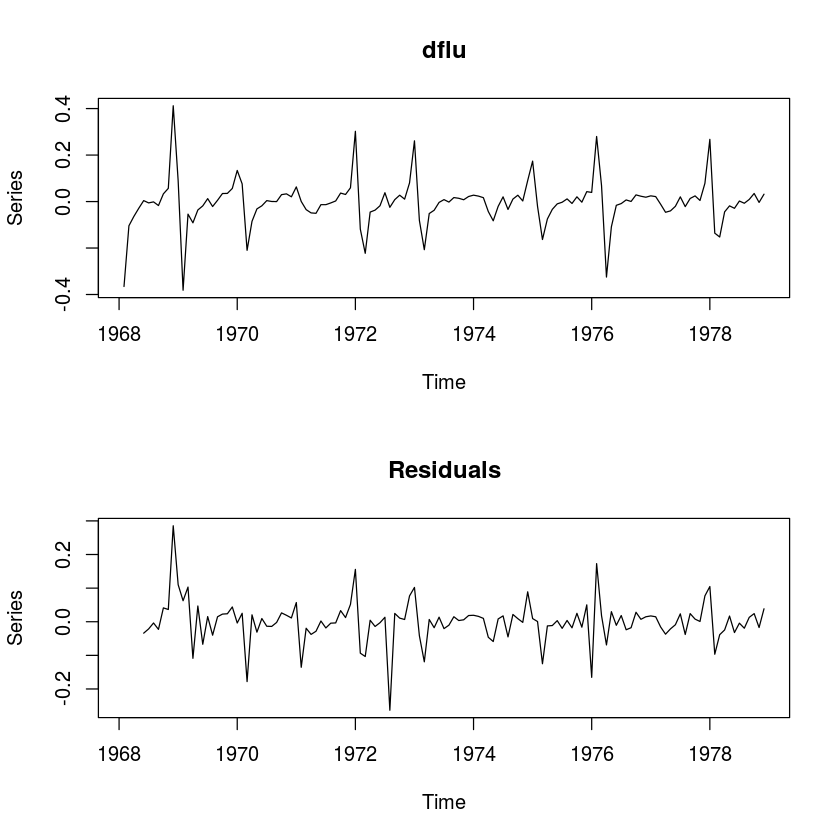

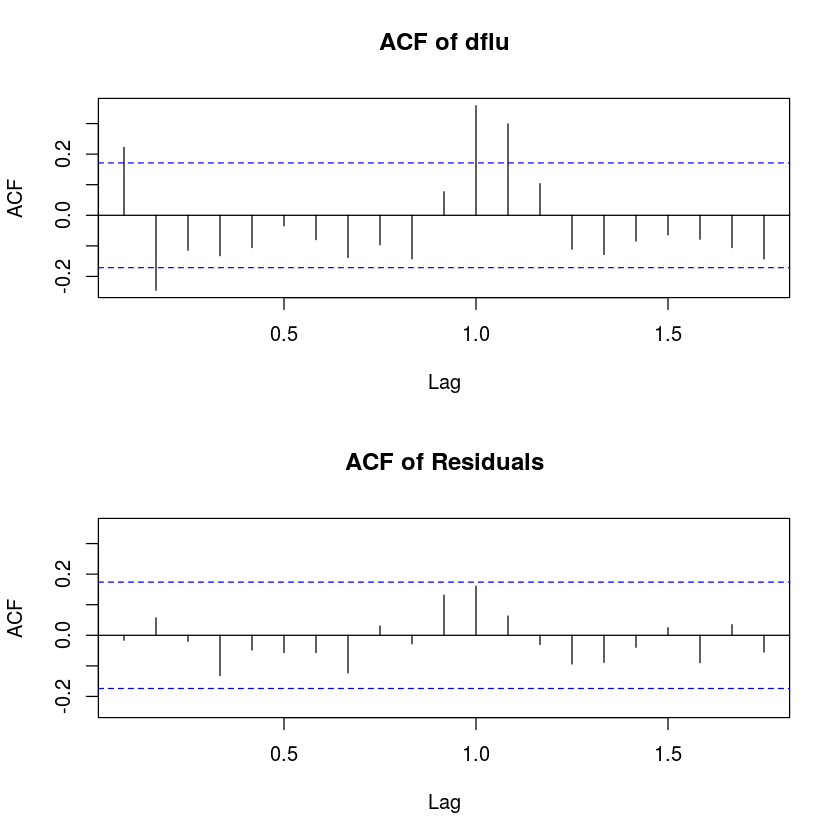

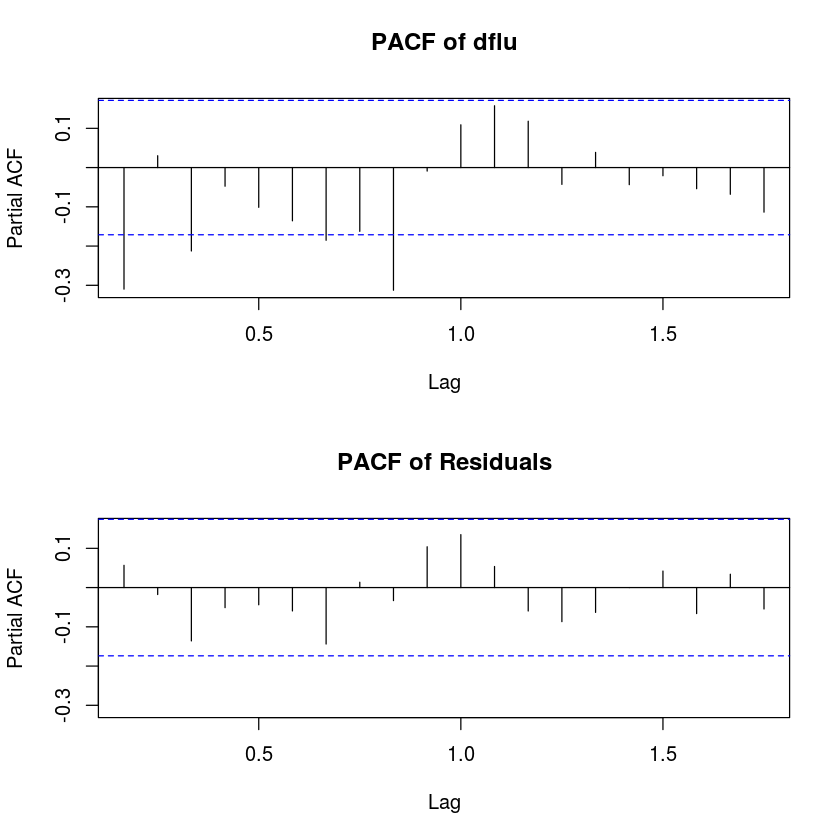

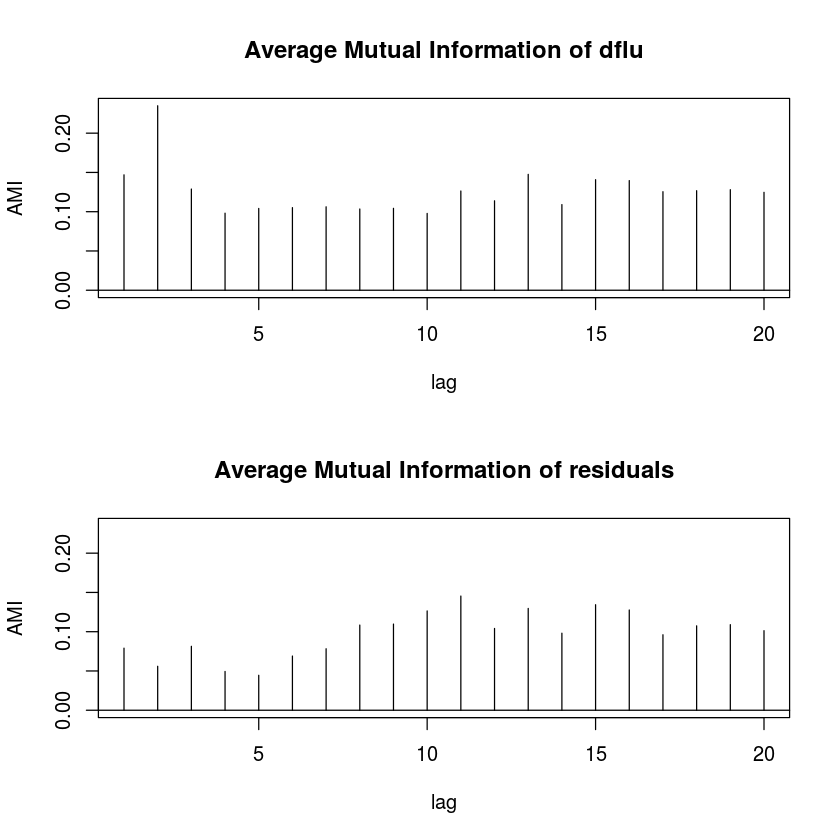

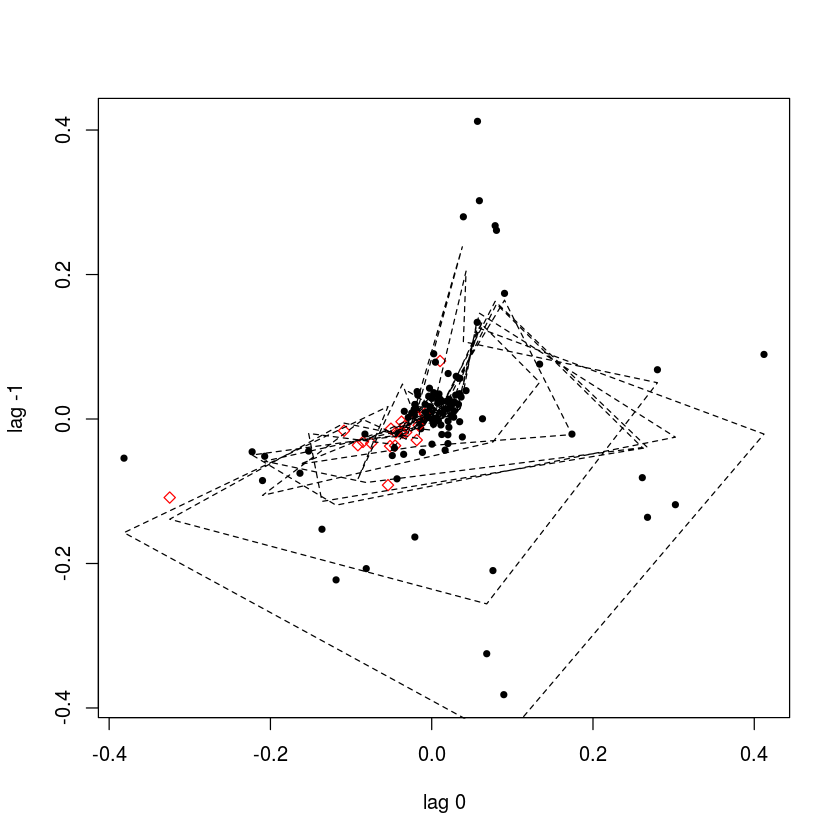

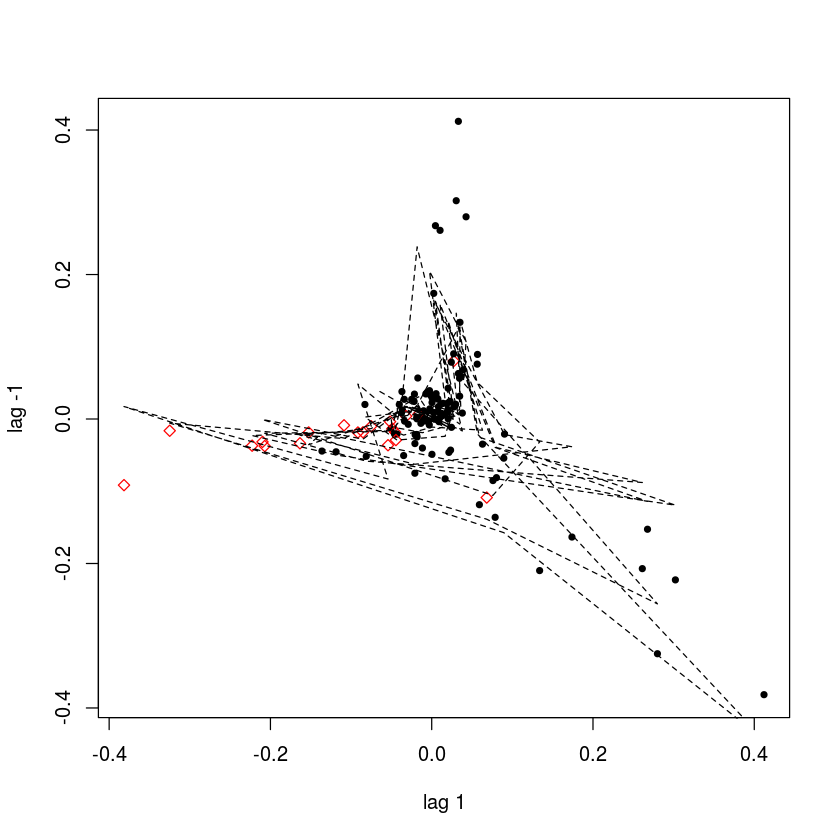

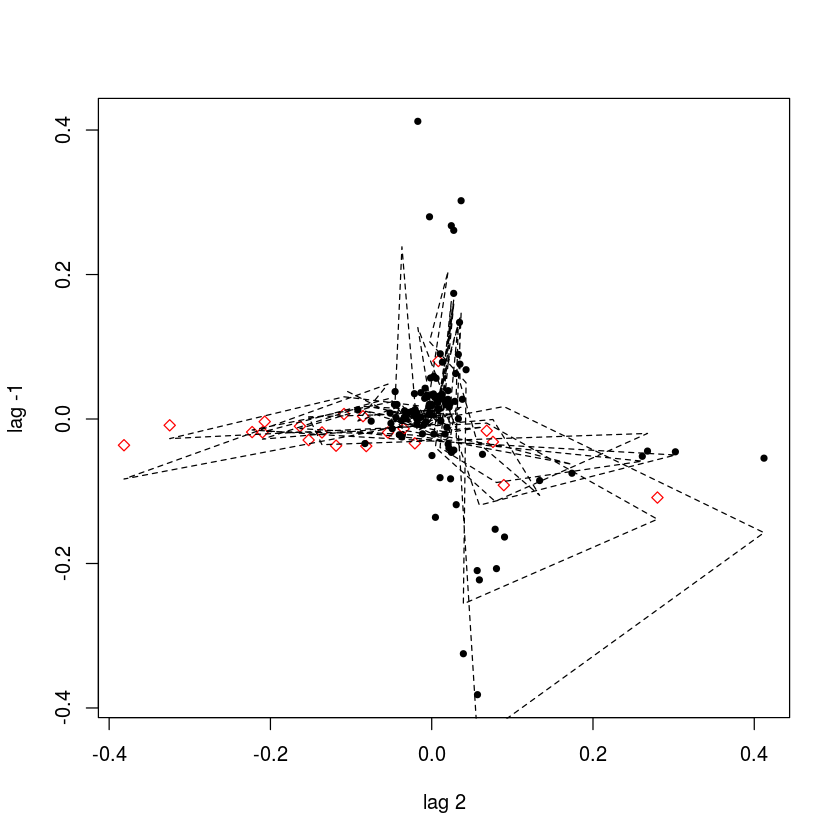

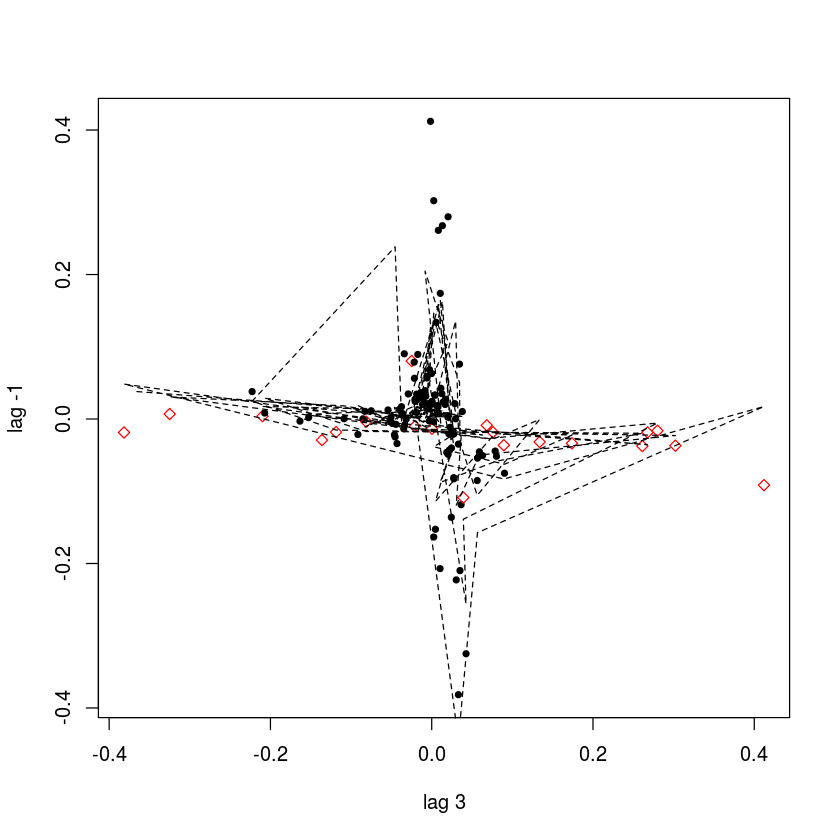

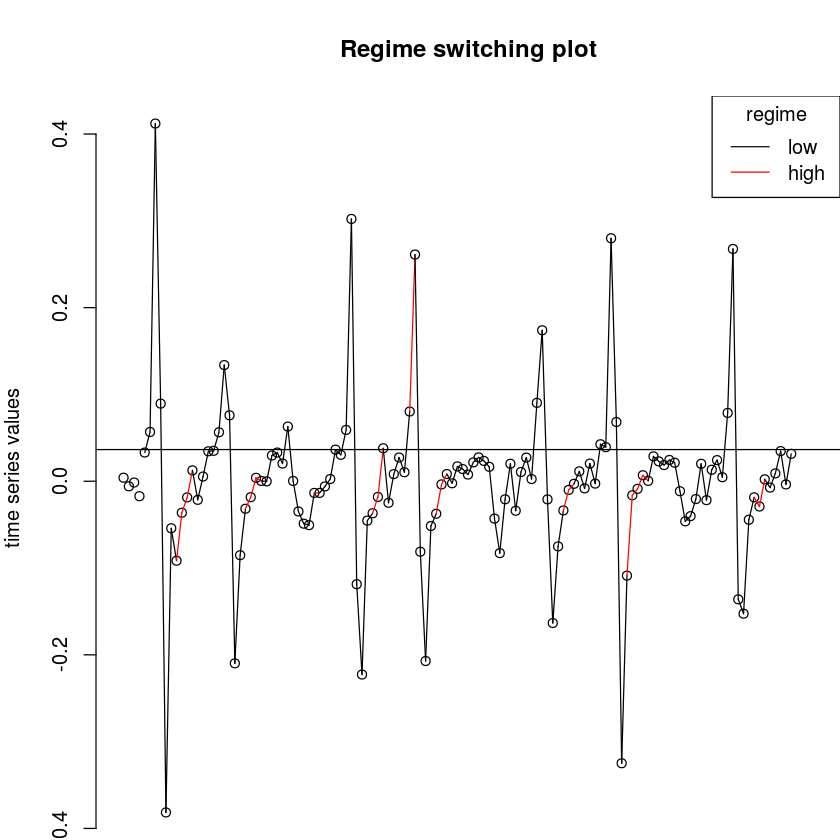

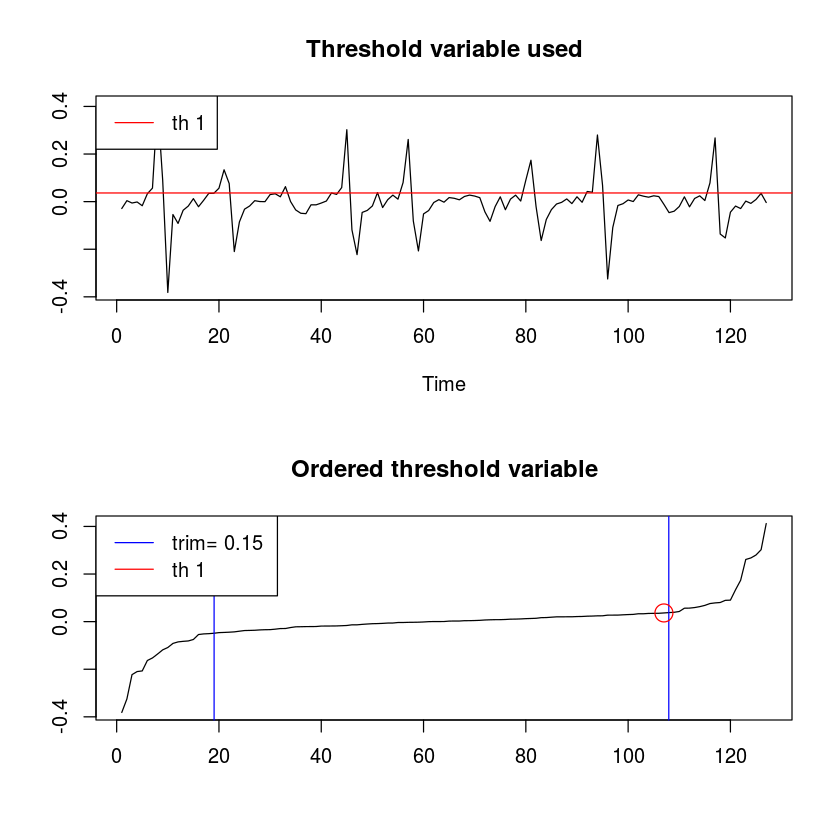

In [31]:
# fit the model and view the results
(u = setar(dflu, m = 4, thDelay = 0, th = 0.05))
(u = setar(dflu, m = 4, thDelay = 0))

#
BIC(u)
AIC(u)
plot(u)

### Switching AR with a HMM and MSwM

We use the hidden states to alter the AR model that we employ at different states:

Markov Switching Model

Call: msmFit(object = model, k = 2, sw = rep(TRUE, 4), p = 2)

        AIC       BIC   logLik
  -438.6622 -392.3445 225.3311

Coefficients:

Regime 1 
---------
               Estimate Std. Error t value  Pr(>|t|)    
(Intercept)(S)   0.0058     0.0027  2.1481  0.031706 *  
dflu_1(S)        0.2931     0.0392  7.4770 7.594e-14 ***
dflu_2(S)        0.0970     0.0312  3.1090  0.001877 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02359005
Multiple R-squared: 0.497

Standardized Residuals:
          Min            Q1           Med            Q3           Max 
-7.374091e-02 -8.017805e-03  1.010047e-11  1.230736e-02  4.700877e-02 

Regime 2 
---------
               Estimate Std. Error t value  Pr(>|t|)    
(Intercept)(S)   0.1989     0.0630  3.1571  0.001593 ** 
dflu_1(S)       -0.3127     0.2806 -1.1144  0.265108    
dflu_2(S)       -1.6042     0.2763 -5.8060 6.398e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.

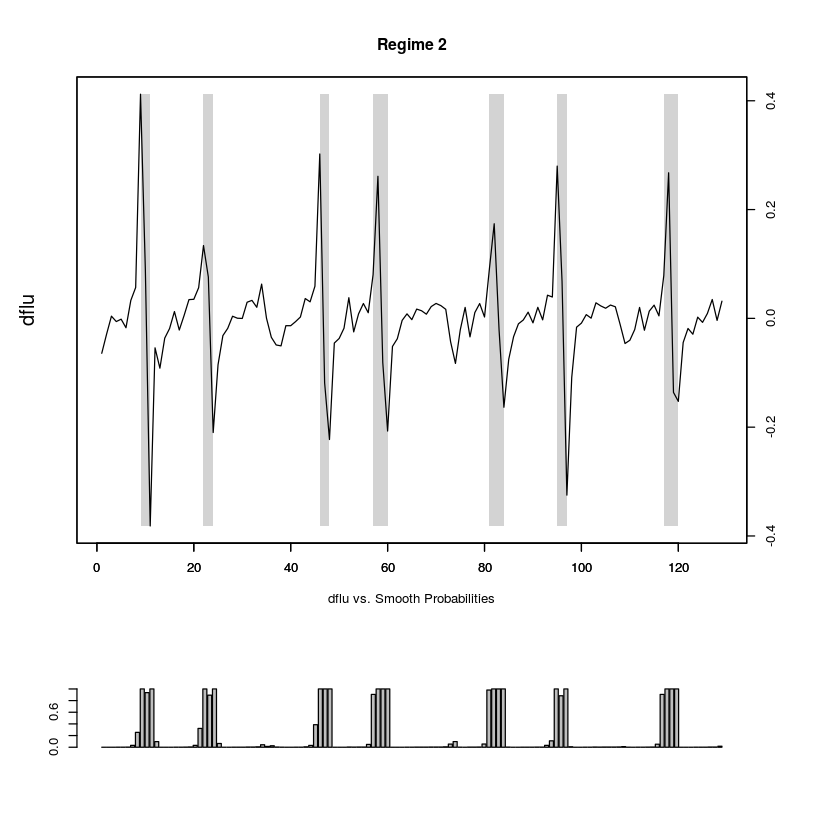

In [32]:
set.seed(90210)

# create a linear model
model = lm(dflu~ 1)

# fit the model to 2 regimes, both of which are AR(2)'s
mod = msmFit(model, k = 2, p = 2, sw = rep(TRUE, 4))
summary(mod)

plotProb(mod, which = 3)